In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
from prophet.plot import add_changepoints_to_plot

In [23]:
df = pd.read_csv('fixed_olympic_ranking.csv')
encoder = LabelEncoder()
df['NOC_CODE'] = encoder.fit_transform(df['NOC_CODE'])
# Đảm bảo dataframe có cột 'ds' và 'y'
df['ds'] = pd.to_datetime(df['Year'], format='%Y')  # Chuyển đổi cột 'Year' thành cột 'ds'
df['y'] = df['Gold']  # Là cột bạn muốn dự đoán



In [24]:
dt = pd.read_csv('fixed_olympic_ranking.csv')
dt =dt[dt['Year'] == 2024]
dt

,Rank,NOC_CODE,Gold,Silver,Bronze,Total,Year,Host,3x3 Basketball,Aeronautics,...,Tennis,Trampoline Gymnastics,Trampolining,Triathlon,Tug-Of-War,Volleyball,Water Polo,Weightlifting,Wrestling,Events
3010,1,USA,40,44,42,126,2024,0,4,0,...,4,0,0,0,0,26,13,2,7,234
3011,2,CHN,40,27,24,91,2024,0,0,0,...,3,2,0,0,0,0,0,5,5,211
3012,3,JPN,20,12,13,45,2024,0,0,0,...,0,0,0,0,0,0,0,0,11,166
3013,4,AUS,18,19,16,53,2024,0,0,0,...,2,0,0,0,0,0,13,0,0,205
3014,5,FRA,16,26,22,64,2024,1,4,0,...,0,0,0,2,0,13,0,0,0,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,77,VIE,0,0,0,0,2024,0,0,0,...,0,0,0,0,0,0,0,0,0,19
3212,77,VIN,0,0,0,0,2024,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3213,77,YEM,0,0,0,0,2024,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3214,77,ZAM,0,0,0,0,2024,0,0,0,...,0,0,0,0,0,0,0,0,0,8


In [25]:
df =df[df['Year'] != 2024]
df

,Rank,NOC_CODE,Gold,Silver,Bronze,Total,Year,Host,3x3 Basketball,Aeronautics,...,Trampolining,Triathlon,Tug-Of-War,Volleyball,Water Polo,Weightlifting,Wrestling,Events,ds,y
0,1,211,11,7,2,20,1896,0,0,0,...,0,0,0,0,0,0,0,16,1896-01-01,11
1,2,78,10,18,19,47,1896,1,0,0,...,0,0,0,0,0,2,2,39,1896-01-01,10
2,3,76,6,5,2,13,1896,0,0,0,...,0,0,0,0,0,0,1,27,1896-01-01,6
3,4,68,5,4,2,11,1896,0,0,0,...,0,0,0,0,0,0,0,18,1896-01-01,5
4,5,72,2,3,2,7,1896,0,0,0,...,0,0,0,0,0,2,0,19,1896-01-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,77,215,0,0,0,0,2020,0,0,0,...,0,0,0,0,0,0,0,21,2020-01-01,0
3006,77,216,0,0,0,0,2020,0,0,0,...,0,0,0,0,0,0,0,3,2020-01-01,0
3007,77,219,0,0,0,0,2020,0,0,0,...,0,0,0,0,0,0,0,6,2020-01-01,0
3008,77,221,0,0,0,0,2020,0,0,0,...,0,0,0,0,0,0,0,10,2020-01-01,0


In [26]:

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.15
)

# Add special seasonality for the Olympic cycle
model.add_seasonality(
    name='4_yearly', 
    period=4*365.25,  # 4 years in days
    fourier_order=8
)

# Add regressors
regressors = df.drop(columns=['y', 'ds', 'Year', 'Rank', 'Gold', 'Silver', 'Bronze', 'Total']).columns
for regressor in regressors:
    model.add_regressor(regressor)
# Fit the model
model.fit(df)

# Make future dataframe for Olympics 2028 for all countries
df_2020 = df[df['Year']==2020]
countries = df_2020['NOC_CODE'].unique()

future = pd.DataFrame({
    'ds': pd.to_datetime(['2024-01-01'] * len(countries)),
    'NOC_CODE': countries,
    'Host': 0,
})

# Add regressors into dataframe future
for regressor in regressors:
    if regressor not in ['NOC_CODE', 'Host']:
        future[regressor] = df_2020[regressor].values




# Predict
forecast = model.predict(future)
# Decode NOC_CODE back to original labels
forecast['NOC_CODE'] = encoder.inverse_transform(countries.astype(int))

# Print forecast
prediction1 = forecast[['NOC_CODE', 'yhat', 'yhat_lower', 'yhat_upper']]
prediction1

22:49:14 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


,NOC_CODE,yhat,yhat_lower,yhat_upper
0,USA,40.567870,38.726431,42.336215
1,CHN,37.798419,36.018070,39.662045
2,JPN,22.560274,20.707896,24.245418
3,GBR,21.242493,19.374501,23.024811
4,AUS,17.330298,15.557143,18.987181
...,...,...,...,...
201,VIE,0.087590,-1.801611,1.872343
202,VIN,0.261568,-1.490805,1.964813
203,YEM,0.236755,-1.564918,1.978635
204,ZAM,0.201029,-1.500167,2.003061


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



# Tính MAE (Mean Absolute Error)
mae = mean_absolute_error(dt['Gold'] , prediction1['yhat'])

# Tính RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(dt['Gold'] , prediction1['yhat']))

# Tính R² (R-squared)
r2 = r2_score(dt['Gold'] , prediction1['yhat'])

# In kết quả
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.5324790415463422
RMSE: 1.0157566666151951
R²: 0.9581227518511297


In [28]:
# Dự đoán trên tập huấn luyện
train_forecast = model.predict(df)
train_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,3x3 Basketball,3x3 Basketball_lower,3x3 Basketball_upper,4_yearly,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1896-01-01,10.486801,4.187884,7.742170,10.486801,10.486801,0.001798,0.001798,0.001798,-2.397313,...,3.036263,3.036263,3.036263,-5.129085,-5.129085,-5.129085,0.0,0.0,0.0,5.996667
1,1896-01-01,10.486801,11.732766,15.186581,10.486801,10.486801,0.001798,0.001798,0.001798,-2.397313,...,10.558745,10.558745,10.558745,-5.129085,-5.129085,-5.129085,0.0,0.0,0.0,13.519149
2,1896-01-01,10.486801,3.820967,7.489376,10.486801,10.486801,0.001798,0.001798,0.001798,-2.397313,...,2.681074,2.681074,2.681074,-5.129085,-5.129085,-5.129085,0.0,0.0,0.0,5.641478
3,1896-01-01,10.486801,1.546314,5.189423,10.486801,10.486801,0.001798,0.001798,0.001798,-2.397313,...,0.416117,0.416117,0.416117,-5.129085,-5.129085,-5.129085,0.0,0.0,0.0,3.376521
4,1896-01-01,10.486801,1.248428,4.653025,10.486801,10.486801,0.001798,0.001798,0.001798,-2.397313,...,-0.010307,-0.010307,-0.010307,-5.129085,-5.129085,-5.129085,0.0,0.0,0.0,2.950097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,2020-01-01,8.836969,-1.629324,1.976335,8.836969,8.836969,0.001798,0.001798,0.001798,-2.381640,...,-1.730911,-1.730911,-1.730911,-4.656571,-4.656571,-4.656571,0.0,0.0,0.0,0.067847
3006,2020-01-01,8.836969,-1.578122,1.939657,8.836969,8.836969,0.001798,0.001798,0.001798,-2.381640,...,-1.556933,-1.556933,-1.556933,-4.656571,-4.656571,-4.656571,0.0,0.0,0.0,0.241825
3007,2020-01-01,8.836969,-1.582328,2.052208,8.836969,8.836969,0.001798,0.001798,0.001798,-2.381640,...,-1.581746,-1.581746,-1.581746,-4.656571,-4.656571,-4.656571,0.0,0.0,0.0,0.217011
3008,2020-01-01,8.836969,-1.556509,1.918956,8.836969,8.836969,0.001798,0.001798,0.001798,-2.381640,...,-1.617473,-1.617473,-1.617473,-4.656571,-4.656571,-4.656571,0.0,0.0,0.0,0.181285


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



# Tính MAE (Mean Absolute Error)
mae = mean_absolute_error(df['Gold'] , train_forecast['yhat'])

# Tính RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(df['Gold'] , train_forecast['yhat']))

# Tính R² (R-squared)
r2 = r2_score(df['Gold'] , train_forecast['yhat'])

# In kết quả
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.6372857010759455
RMSE: 1.4006263173873157
R²: 0.9455250842220999


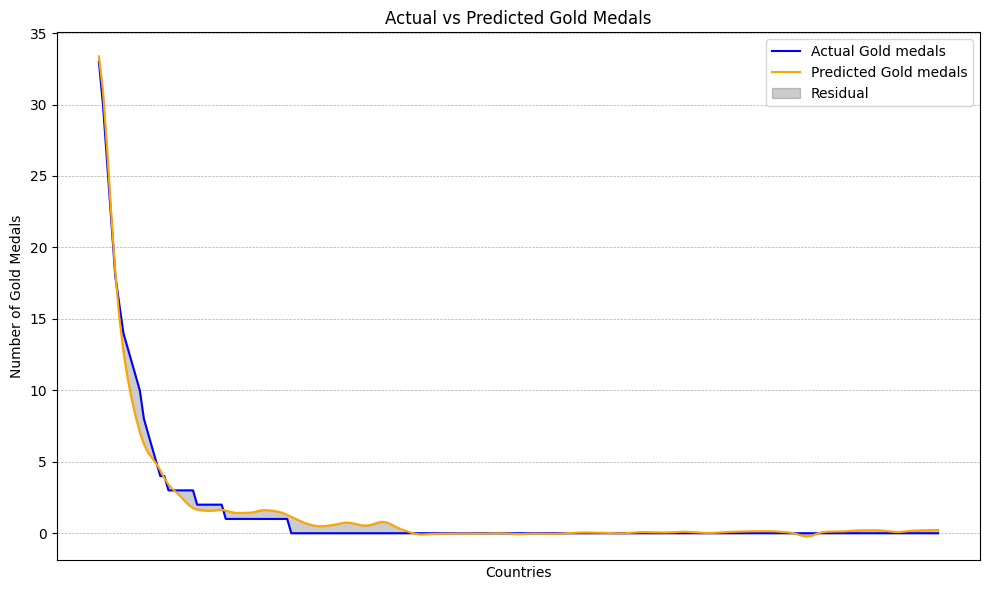

In [30]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu
x = np.arange(len(prediction1['NOC_CODE']))
y_actual = dt["Gold"]
y_predicted = prediction1['yhat']

# Làm mượt dữ liệu bằng Gaussian Filter
sigma = 2  # Độ mượt (tăng sigma để làm mượt hơn)
y_actual_smooth = gaussian_filter1d(y_actual, sigma=sigma)
y_predicted_smooth = gaussian_filter1d(y_predicted, sigma=sigma)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ đường thực tế và dự đoán sau khi làm mượt
plt.plot(x, y_actual_smooth, label="Actual Gold medals", color="blue")
plt.plot(x, y_predicted_smooth, label="Predicted Gold medals", color="orange")

# Tô bóng phần giữa hai đường làm mượt
plt.fill_between(
    x,
    y_actual_smooth,
    y_predicted_smooth,
    color="black",
    alpha=0.2,
    label="Residual"
)
plt.xticks([])  # Ẩn nhãn trục x
plt.title("Actual vs Predicted Gold Medals")
plt.xlabel("Countries")
plt.ylabel("Number of Gold Medals")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hiển thị biểu đồ
plt.show()
